In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
from IPython.display import HTML
import os
import torchvision

## Utils

In [ ]:
def unorm(x):
  return (x - x.min()) / (x.max() - x.min())

In [ ]:
def plot_sample(samples, n_sample, nrows):
    ncols = n_sample//nrows
    samples = unorm(samples.cpu())
    # Create a figure with subplots
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Loop through each image and plot it
    for i in range(n_sample):
        # Select image
        image = samples[i]  # Shape [3, 16, 16]

        # Transpose to [16, 16, 3] for plotting
        image = image.permute(1, 2, 0)


        # Plot the image in the appropriate subplot
        axes[i].imshow(image)
        axes[i].axis('off')  # Hide axis
        axes[i].set_title(f'Image {i + 1}')  # Set title

    # Hide any unused subplots
    for j in range(n_sample, nrows * ncols):
        axes[j].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

## hyperparameters


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# diffusion hyperparameters
num_timesteps = 1000
beta_start = 1e-4
beta_end = 0.02
# network hyperparameters
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = '/content/drive/MyDrive/DDPM'
os.makedirs(save_dir, exist_ok=True)
# training hyperparameters
batch_size = 100
n_epoch = 70
lrate=1e-3
save_path=save_dir

## Sprites Dataset

In [ ]:
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy'
!wget 'https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprite_labels_nc_1788_16x16.npy'

--2024-12-22 18:01:38--  https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/a24918819843abc0d1bee75a239024415081a87d/sprites_1788_16x16.npy
Resolving huggingface.co (huggingface.co)... 13.33.45.10, 13.33.45.37, 13.33.45.68, ...
Connecting to huggingface.co (huggingface.co)|13.33.45.10|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/df/b9/dfb98dd9f5f7c221e653770544f82ac8de0044d1f52ab71a1e42ed1a332ae365/61cf3b7e3184f57f2bc2bf5e75fbcf08ba379241f58966c62a9716ef581b2916?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27sprites_1788_16x16.npy%3B+filename%3D%22sprites_1788_16x16.npy%22%3B&Expires=1735149699&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTczNTE0OTY5OX19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2RmL2I5L2RmYjk4ZGQ5ZjVmN2MyMjFlNjUzNzcwNTQ0ZjgyYWM4ZGUwMDQ0ZDFmNTJhYjcxYTFlNDJlZDFhMzMyYWUzNjUvNjFjZjNiN2UzMTg0ZjU3ZjJiYzJiZjVlNz

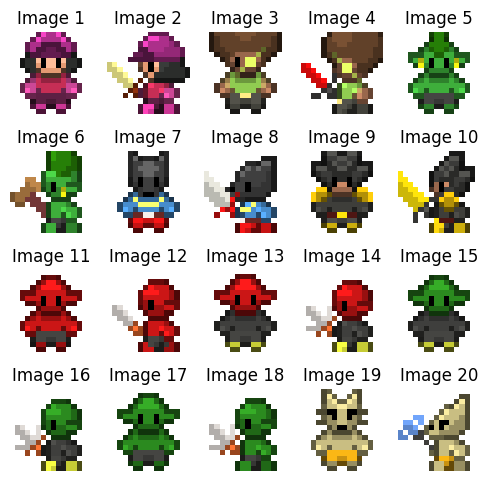

In [ ]:
sprites_samples = np.load("/content/sprites_1788_16x16.npy")[:20]
num_rows = 4
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(5, 5))
axes = axes.flatten()

# Loop through each image and plot it
for i in range(20):
    image = sprites_samples[i]

    # Plot the image in the appropriate subplot
    axes[i].imshow(image)
    axes[i].axis('off')  # Hide axis
    axes[i].set_title(f'Image {i + 1}')  # Set title

# Hide any unused subplots
for j in range(20, num_rows * num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
    def __init__(self, _sprites, _slabels, transform, null_context=False):
        self.transform = transform
        self.null_context = null_context
        self.sprites = _sprites
        self.slabels = _slabels
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return image#, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape#, self.slabel_shape

transform = transforms.Compose([
    transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
    transforms.Normalize((0.5,), (0.5,))  # range [-1,1]
])

In [ ]:
sprites = np.load("/content/sprites_1788_16x16.npy")
slabels = np.load("/content/sprite_labels_nc_1788_16x16.npy")

print(f"sprite shape: {sprites.shape}")
print(f"labels shape: {slabels.shape}")


train_sprites = sprites[:60000]
train_slabels = slabels[:60000]
val_sprites = sprites[60000:]
val_slabels = slabels[60000:]

sprite shape: (89400, 16, 16, 3)
labels shape: (89400, 5)


In [ ]:
# load dataset
trian_dataset = CustomDataset(train_sprites, train_slabels, transform, null_context=False)
train_dataloader = DataLoader(trian_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# load dataset
val_dataset = CustomDataset(val_sprites, val_slabels, transform, null_context=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=1)

## UNet

So what model do we use to do this magical 'denoising' step? We've looked a little at basic convolutional neural networks that take in an image and output something like a classification. And we've seen autoencoders that go from an image down to a latent representation and back to an output image. Perhaps one of these would be suitable?

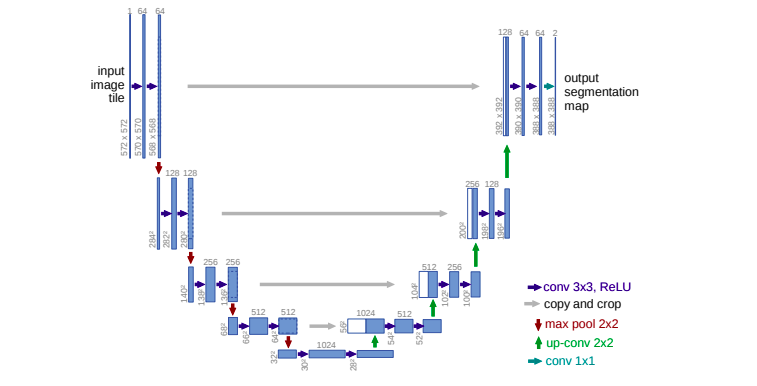

(Unet diagram from [the 2015 paper](https://arxiv.org/abs/1505.04597))

One issue with a typical 'bottlekneck' architecture like an autoencoder is that by design they loose the details around exact pixel coordinates. To get around this, an architecture called the Unet was introduced. Originally designed for segmentation tasks, the architecture (shown above) passes information from high-resolution, early layers to later layers. These 'shortcuts' let the network use detailed features from the original image while also capturing more high-level semantic information from the deeper layers.

These networks turned out to be great at all sorts of image-to-image tasks. Colorization , segmentation and so on. These days, typical unet models incorporate ideas such as attention and can be built around pretrained 'backbones' like resnet-50 for transfer learning tasks.

The implementation below is a fairly typical modern Unet with one extra trick: a TimeEmbedding which encodes the time step (t) and lets the model use this as conditioning information by passing it in in the middle of the network. Take a peek at the code and see if you can figure out roughly what's going on in the forward pass.



In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

In [ ]:
class Unet(nn.Module):
    def __init__(self, in_channels, n_feat=256, n_cfeat=10, height=28):  # cfeat - context features
        super(Unet, self).__init__()

        # number of input channels, number of intermediate feature maps and number of classes
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4, so 28,24,20,16...

        # Initialize the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True)

        # Initialize the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # down1 #[10, 256, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # down2 #[10, 256, 4,  4]

         # original: self.to_vec = nn.Sequential(nn.AvgPool2d(7), nn.GELU())
        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU())

        # Embed the timestep and context labels with a one-layer fully connected neural network
        self.timeembed1 = EmbedFC(1, 2*n_feat)
        self.timeembed2 = EmbedFC(1, 1*n_feat)
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat)
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat)

        # Initialize the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        )
        self.up1 = UnetUp(4 * n_feat, n_feat)
        self.up2 = UnetUp(2 * n_feat, n_feat)

        # Initialize the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1), # reduce number of feature maps   #in_channels, out_channels, kernel_size, stride=1, padding=0
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1), # map to same number of channels as input
        )

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, n_cfeat)      : time step
        c : (batch, n_classes)    : context label
        """
        # x is the input image, c is the context label, t is the timestep, context_mask says which samples to block the context on

        # pass the input image through the initial convolutional layer
        x = self.init_conv(x)
        # pass the result through the down-sampling path
        down1 = self.down1(x)       #[10, 256, 8, 8]
        down2 = self.down2(down1)   #[10, 256, 4, 4]

        # convert the feature maps to a vector and apply an activation
        hiddenvec = self.to_vec(down2)

        # mask out context if context_mask == 1
        if c is None:
            c = torch.zeros(x.shape[0], self.n_cfeat).to(x)

        # embed context and timestep
        cemb1 = self.contextembed1(c).view(-1, self.n_feat * 2, 1, 1)     # (batch, 2*n_feat, 1,1)
        temb1 = self.timeembed1(t).view(-1, self.n_feat * 2, 1, 1)
        cemb2 = self.contextembed2(c).view(-1, self.n_feat, 1, 1)
        temb2 = self.timeembed2(t).view(-1, self.n_feat, 1, 1)
        #print(f"uunet forward: cemb1 {cemb1.shape}. temb1 {temb1.shape}, cemb2 {cemb2.shape}. temb2 {temb2.shape}")


        up1 = self.up0(hiddenvec)
        up2 = self.up1(cemb1*up1 + temb1, down2)  # add and multiply embeddings
        up3 = self.up2(cemb2*up2 + temb2, down1)
        out = self.out(torch.cat((up3, x), 1))
        return out

## Training

In [ ]:
nn_model = Unet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)

In [ ]:
optimizer = torch.optim.Adam(nn_model.parameters(), lr=lrate)
criterion = torch.nn.MSELoss()

We want to set up a "**variance schedule**" β, where $\beta_t$ specifies how much noise we want to add at that step. You get fancy schedules but we'll stick with a linear one for now. \\
At each time step t, the variance of the noise added to the previous step is predetermined by the variance schedule, and it's marked as $\beta_t$, where 0 < $\beta_1$ < $\beta_t$ < $\beta_2$ < 1.

In [ ]:
betas = torch.linspace(beta_start, beta_end, num_timesteps)
alphas = 1. - betas
alpha_cum_prod = torch.cumprod(alphas, dim=0)
sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod)
sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod)

## Forward - Noising


In [ ]:
def perturb_input (original, noise, t,sqrt_alpha_cum_prod=sqrt_alpha_cum_prod,sqrt_one_minus_alpha_cum_prod=sqrt_one_minus_alpha_cum_prod): #forward diffusion process (adding noise).
    original_shape = original.shape
    batch_size = original_shape[0]
    # ¯α_t = ∏ α_i
    sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.to(original.device)[t].reshape(batch_size)
    # 1- ¯α_t = 1- ∏ α_i
    sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.to(original.device)[t].reshape(batch_size)

    # reshape till (B,) becomes (B,1,1,1) if image is (B,C,H,W)(Stretching for mat mul)
    for _ in range(len(original_shape) - 1):
        sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
    for _ in range(len(original_shape) - 1):
        sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

    # Xt= sqrt(¯αt).X0 + sqrt(1-¯α_t).ϵ
    return (sqrt_alpha_cum_prod.to(original.device)*original + sqrt_one_minus_alpha_cum_prod.to(original.device)*noise)

In [ ]:
im.shape

torch.Size([100, 3, 16, 16])

## Backward - Denoising

In [ ]:
def reverse(xt, noise_pred, t,eta=0.5,model_type="DDPM"):#reverse diffusion process (denoising)
  #X0≈ = ( x_t - √(1-¯α_t ).                                       ϵ_θ(x_t))   /  √(¯α_t )
    x0 = ((xt - (sqrt_one_minus_alpha_cum_prod.to(xt.device)[t] * noise_pred)) / (sqrt_alpha_cum_prod.to(xt.device)[t]))
    x0 = torch.clamp(x0, -1., 1.)
   #x0: Estimated Clean Data

    #   mean=  x_t -( (1-α_t)                  .ϵ_θ(x_t)     / √(1-(¯α_t )
    mean = xt  -( (betas.to(xt.device)[t]) * noise_pred) / (sqrt_one_minus_alpha_cum_prod.to(xt.device)[t])
    mean = mean / torch.sqrt(alphas.to(xt.device)[t]) #  / √(α_t )

           #   (1-  ¯α_t-1)                              / (1   -¯α_t)
    variance = (1 - alpha_cum_prod.to(xt.device)[t - 1]) / (1.0 - alpha_cum_prod.to(xt.device)[t])
    variance = variance * betas.to(xt.device)[t] # *(1- α_t)
    sigma = torch.sqrt(variance)   # √var

    if model_type=="DDPM":
        if t == 0:    return mean, x0
        else:
            z = torch.randn(xt.shape).to(xt.device)
            x_t_1=(mean + sigma * z) #a noisy sample x_t-1

    elif model_type=="DDIM" :
        if eta > 0:
            z = torch.randn_like(xt).to(xt.device)
            x_t_1 =mean + sigma * eta * z
        else:
            x_t_1 = mean

    return x_t_1, x0


## Train Diffsion

Now that we have our 'diffusion model' defined, we need to train it to predict the noise given $x_t$ and $t$.

In [ ]:
# Train Model
nn_model.train()
train_loss_epoch=[]
val_loss_epoch=[]
for ep in range(n_epoch):
    print(f'Epoch {ep}')
    train_losses = []
    # Training Loop
    for im in tqdm(train_dataloader):
        optimizer.zero_grad()
        im = im.float().to(device)

        noise = torch.randn_like(im).to(device)  # Sample random noise
        t = torch.randint(0, num_timesteps, (im.shape[0],)).to(device)  # Sample timestep
        noisy_image = perturb_input(im, noise, t)  # Add noise to images according to timestep
        noise_pred = nn_model(noisy_image, t.float())

        loss = criterion(noise_pred, noise)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    # Log training loss
    avg_train_loss = np.mean(train_losses)
    train_loss_epoch.append(avg_train_loss)
    print(f'  \nEpoch: {ep + 1} | Training Loss: {avg_train_loss:.4f}')

    # Validation Loop
    nn_model.eval()
    val_losses = []
    with torch.no_grad():
        for val_im in val_dataloader:
            val_im = val_im.float().to(device)

            noise = torch.randn_like(val_im).to(device)
            t = torch.randint(0, num_timesteps, (val_im.shape[0],)).to(device)
            noisy_val_im = perturb_input(val_im, noise, t)
            noise_pred = nn_model(noisy_val_im, t.float())

            val_loss = criterion(noise_pred, noise)
            val_losses.append(val_loss.item())

    # Log validation loss
    avg_val_loss = np.mean(val_losses)
    val_loss_epoch.append(avg_val_loss)
    print(f'Validation Loss: {avg_val_loss:.4f}')

    torch.save(nn_model.state_dict(), os.path.join(save_dir, f'Epoch_{ep}_checkpoint.pth'))

print('Done Training ...')

Epoch 0


100%|██████████| 600/600 [00:22<00:00, 26.29it/s]

  
Epoch: 1 | Training Loss: 0.2057


Validation Loss: 0.1505
Epoch 1


100%|██████████| 600/600 [00:21<00:00, 27.69it/s]

  
Epoch: 2 | Training Loss: 0.1118


Validation Loss: 0.0972
Epoch 2


100%|██████████| 600/600 [00:20<00:00, 28.86it/s]

  
Epoch: 3 | Training Loss: 0.0919


Validation Loss: 0.0866
Epoch 3


100%|██████████| 600/600 [00:20<00:00, 28.90it/s]

  
Epoch: 4 | Training Loss: 0.0834


Validation Loss: 0.0816
Epoch 4


100%|██████████| 600/600 [00:20<00:00, 28.71it/s]

  
Epoch: 5 | Training Loss: 0.0784


Validation Loss: 0.0798
Epoch 5


100%|██████████| 600/600 [00:22<00:00, 27.26it/s]

  
Epoch: 6 | Training Loss: 0.0758


Validation Loss: 0.0742
Epoch 6


100%|██████████| 600/600 [00:22<00:00, 26.75it/s]

  
Epoch: 7 | Training Loss: 0.0735


Validation Loss: 0.0717
Epoch 7


100%|██████████| 600/600 [00:21<00:00, 28.04it/s]

  
Epoch: 8 | Training Loss: 0.0709


Validation Loss: 0.0732
Epoch 8


100%|██████████| 600/600 [00:20<00:00, 28.63it/s]

  
Epoch: 9 | Training Loss: 0.0695


Validation Loss: 0.0700
Epoch 9


100%|██████████| 600/600 [00:20<00:00, 28.89it/s]

  
Epoch: 10 | Training Loss: 0.0674


Validation Loss: 0.0662
Epoch 10


100%|██████████| 600/600 [00:20<00:00, 28.88it/s]

  
Epoch: 11 | Training Loss: 0.0666


Validation Loss: 0.0652
Epoch 11


100%|██████████| 600/600 [00:21<00:00, 27.31it/s]

  
Epoch: 12 | Training Loss: 0.0649


Validation Loss: 0.0643
Epoch 12


100%|██████████| 600/600 [00:21<00:00, 27.50it/s]

  
Epoch: 13 | Training Loss: 0.0631


Validation Loss: 0.0630
Epoch 13


100%|██████████| 600/600 [00:20<00:00, 29.07it/s]

  
Epoch: 14 | Training Loss: 0.0623


Validation Loss: 0.0622
Epoch 14


100%|██████████| 600/600 [00:20<00:00, 29.14it/s]

  
Epoch: 15 | Training Loss: 0.0602


Validation Loss: 0.0589
Epoch 15


100%|██████████| 600/600 [00:20<00:00, 29.17it/s]

  
Epoch: 16 | Training Loss: 0.0596


Validation Loss: 0.0602
Epoch 16


100%|██████████| 600/600 [00:21<00:00, 27.68it/s]

  
Epoch: 17 | Training Loss: 0.0590


Validation Loss: 0.0576
Epoch 17


100%|██████████| 600/600 [00:22<00:00, 27.05it/s]

  
Epoch: 18 | Training Loss: 0.0588


Validation Loss: 0.0585
Epoch 18


100%|██████████| 600/600 [00:20<00:00, 28.81it/s]

  
Epoch: 19 | Training Loss: 0.0576


Validation Loss: 0.0575
Epoch 19


100%|██████████| 600/600 [00:20<00:00, 29.02it/s]

  
Epoch: 20 | Training Loss: 0.0566


Validation Loss: 0.0560
Epoch 20


100%|██████████| 600/600 [00:20<00:00, 29.12it/s]

  
Epoch: 21 | Training Loss: 0.0558


Validation Loss: 0.0544
Epoch 21


100%|██████████| 600/600 [00:21<00:00, 27.90it/s]

  
Epoch: 22 | Training Loss: 0.0540


Validation Loss: 0.0530
Epoch 22


100%|██████████| 600/600 [00:22<00:00, 27.04it/s]

  
Epoch: 23 | Training Loss: 0.0549


Validation Loss: 0.0545
Epoch 23


100%|██████████| 600/600 [00:20<00:00, 28.59it/s]

  
Epoch: 24 | Training Loss: 0.0540


Validation Loss: 0.0548
Epoch 24


100%|██████████| 600/600 [00:20<00:00, 29.09it/s]

  
Epoch: 25 | Training Loss: 0.0529


Validation Loss: 0.0529
Epoch 25


100%|██████████| 600/600 [00:20<00:00, 29.21it/s]

  
Epoch: 26 | Training Loss: 0.0526


Validation Loss: 0.0526
Epoch 26


100%|██████████| 600/600 [00:21<00:00, 28.04it/s]

  
Epoch: 27 | Training Loss: 0.0513


Validation Loss: 0.0510
Epoch 27


100%|██████████| 600/600 [00:22<00:00, 27.18it/s]

  
Epoch: 28 | Training Loss: 0.0521


Validation Loss: 0.0498
Epoch 28


100%|██████████| 600/600 [00:20<00:00, 28.82it/s]

  
Epoch: 29 | Training Loss: 0.0508


Validation Loss: 0.0514
Epoch 29


100%|██████████| 600/600 [00:20<00:00, 29.08it/s]

  
Epoch: 30 | Training Loss: 0.0497


Validation Loss: 0.0488
Epoch 30


100%|██████████| 600/600 [00:20<00:00, 29.28it/s]

  
Epoch: 31 | Training Loss: 0.0496


Validation Loss: 0.0490
Epoch 31


100%|██████████| 600/600 [00:21<00:00, 27.72it/s]

  
Epoch: 32 | Training Loss: 0.0496


Validation Loss: 0.0492
Epoch 32


100%|██████████| 600/600 [00:21<00:00, 27.55it/s]

  
Epoch: 33 | Training Loss: 0.0492


Validation Loss: 0.0482
Epoch 33


100%|██████████| 600/600 [00:20<00:00, 29.23it/s]

  
Epoch: 34 | Training Loss: 0.0487


Validation Loss: 0.0471
Epoch 34


100%|██████████| 600/600 [00:20<00:00, 29.32it/s]

  
Epoch: 35 | Training Loss: 0.0478


Validation Loss: 0.0477
Epoch 35


100%|██████████| 600/600 [00:20<00:00, 29.28it/s]

  
Epoch: 36 | Training Loss: 0.0476


Validation Loss: 0.0469
Epoch 36


100%|██████████| 600/600 [00:21<00:00, 28.09it/s]

  
Epoch: 37 | Training Loss: 0.0475


Validation Loss: 0.0466
Epoch 37


100%|██████████| 600/600 [00:21<00:00, 27.61it/s]

  
Epoch: 38 | Training Loss: 0.0464


Validation Loss: 0.0467
Epoch 38


100%|██████████| 600/600 [00:20<00:00, 29.02it/s]

  
Epoch: 39 | Training Loss: 0.0465


Validation Loss: 0.0450
Epoch 39


100%|██████████| 600/600 [00:20<00:00, 29.12it/s]

  
Epoch: 40 | Training Loss: 0.0460


Validation Loss: 0.0450
Epoch 40


100%|██████████| 600/600 [00:20<00:00, 29.22it/s]

  
Epoch: 41 | Training Loss: 0.0457


Validation Loss: 0.0462
Epoch 41


100%|██████████| 600/600 [00:21<00:00, 27.70it/s]

  
Epoch: 42 | Training Loss: 0.0456


Validation Loss: 0.0456
Epoch 42


100%|██████████| 600/600 [00:21<00:00, 27.53it/s]

  
Epoch: 43 | Training Loss: 0.0459


Validation Loss: 0.0449
Epoch 43


100%|██████████| 600/600 [00:20<00:00, 28.73it/s]

  
Epoch: 44 | Training Loss: 0.0451


Validation Loss: 0.0450
Epoch 44


100%|██████████| 600/600 [00:20<00:00, 29.30it/s]

  
Epoch: 45 | Training Loss: 0.0457


Validation Loss: 0.0460
Epoch 45


100%|██████████| 600/600 [00:20<00:00, 29.25it/s]

  
Epoch: 46 | Training Loss: 0.0450


Validation Loss: 0.0449
Epoch 46


100%|██████████| 600/600 [00:21<00:00, 27.77it/s]

  
Epoch: 47 | Training Loss: 0.0448


Validation Loss: 0.0449
Epoch 47


100%|██████████| 600/600 [00:21<00:00, 27.44it/s]

  
Epoch: 48 | Training Loss: 0.0443


Validation Loss: 0.0438
Epoch 48


100%|██████████| 600/600 [00:20<00:00, 29.16it/s]


  
Epoch: 49 | Training Loss: 0.0441
Validation Loss: 0.0430
Epoch 49


100%|██████████| 600/600 [00:20<00:00, 29.30it/s]

  
Epoch: 50 | Training Loss: 0.0431


Validation Loss: 0.0432
Epoch 50


100%|██████████| 600/600 [00:20<00:00, 28.90it/s]

  
Epoch: 51 | Training Loss: 0.0434


Validation Loss: 0.0438
Epoch 51


100%|██████████| 600/600 [00:21<00:00, 27.28it/s]

  
Epoch: 52 | Training Loss: 0.0437


Validation Loss: 0.0430
Epoch 52


100%|██████████| 600/600 [00:21<00:00, 28.20it/s]

  
Epoch: 53 | Training Loss: 0.0434


Validation Loss: 0.0429
Epoch 53


100%|██████████| 600/600 [00:20<00:00, 29.21it/s]

  
Epoch: 54 | Training Loss: 0.0427


Validation Loss: 0.0428
Epoch 54


100%|██████████| 600/600 [00:20<00:00, 29.28it/s]

  
Epoch: 55 | Training Loss: 0.0426


Validation Loss: 0.0417
Epoch 55


100%|██████████| 600/600 [00:21<00:00, 28.54it/s]

  
Epoch: 56 | Training Loss: 0.0430


Validation Loss: 0.0427
Epoch 56


100%|██████████| 600/600 [00:21<00:00, 27.28it/s]

  
Epoch: 57 | Training Loss: 0.0427


Validation Loss: 0.0418
Epoch 57


100%|██████████| 600/600 [00:20<00:00, 28.62it/s]

  
Epoch: 58 | Training Loss: 0.0425


Validation Loss: 0.0419
Epoch 58


100%|██████████| 600/600 [00:20<00:00, 29.28it/s]

  
Epoch: 59 | Training Loss: 0.0420


Validation Loss: 0.0415
Epoch 59


100%|██████████| 600/600 [00:20<00:00, 29.17it/s]

  
Epoch: 60 | Training Loss: 0.0417


Validation Loss: 0.0407
Epoch 60


100%|██████████| 600/600 [00:21<00:00, 28.08it/s]

  
Epoch: 61 | Training Loss: 0.0416


Validation Loss: 0.0416
Epoch 61


100%|██████████| 600/600 [00:22<00:00, 27.21it/s]

  
Epoch: 62 | Training Loss: 0.0416


Validation Loss: 0.0417
Epoch 62


100%|██████████| 600/600 [00:20<00:00, 29.06it/s]

  
Epoch: 63 | Training Loss: 0.0411


Validation Loss: 0.0413
Epoch 63


100%|██████████| 600/600 [00:20<00:00, 29.18it/s]

  
Epoch: 64 | Training Loss: 0.0412


Validation Loss: 0.0409
Epoch 64


100%|██████████| 600/600 [00:20<00:00, 29.27it/s]

  
Epoch: 65 | Training Loss: 0.0406


Validation Loss: 0.0416
Epoch 65


100%|██████████| 600/600 [00:21<00:00, 27.68it/s]

  
Epoch: 66 | Training Loss: 0.0407


Validation Loss: 0.0398
Epoch 66


100%|██████████| 600/600 [00:21<00:00, 28.11it/s]

  
Epoch: 67 | Training Loss: 0.0402


Validation Loss: 0.0404
Epoch 67


100%|██████████| 600/600 [00:20<00:00, 29.26it/s]

  
Epoch: 68 | Training Loss: 0.0404


Validation Loss: 0.0404
Epoch 68


100%|██████████| 600/600 [00:20<00:00, 29.38it/s]

  
Epoch: 69 | Training Loss: 0.0401


Validation Loss: 0.0407
Epoch 69


100%|██████████| 600/600 [00:20<00:00, 28.67it/s]

  
Epoch: 70 | Training Loss: 0.0399


Validation Loss: 0.0408
Done Training ...


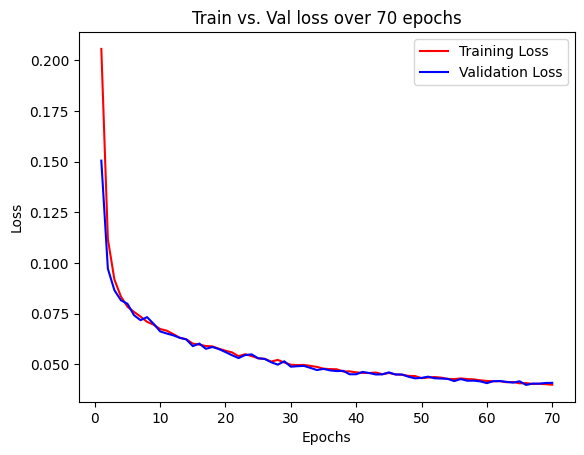

In [ ]:
plt.plot(np.arange(1,n_epoch+1),train_loss_epoch,c='red',label='Training Loss')
plt.plot(np.arange(1,n_epoch+1),val_loss_epoch,c='blue',label='Validation Loss')
plt.title(f'Train vs. Val loss over {n_epoch} epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## DDPM Sampling

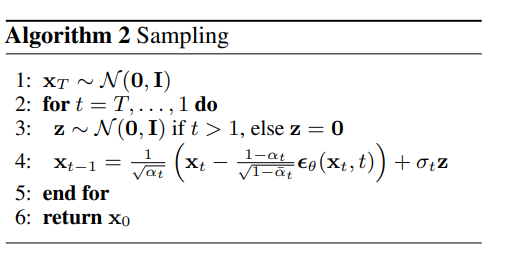

### plot_generated_images

In [ ]:
def plot_generated_images(images, num_images=None, figsize=(8,8), normalize=True):
    images = images[:num_images]
    num_images=len(images)
    if normalize:
        images = (images + 1) / 2

    images = images.permute(0, 2, 3, 1).cpu().detach().numpy()
    grid_size = int(num_images ** 0.5)
    fig, axes = plt.subplots(grid_size, grid_size, figsize=figsize)
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.axis("off")
        else:  ax.axis("off")

    plt.tight_layout()
    plt.show()

## generate images

In [ ]:
def generate_images(model, num_images, num_timesteps, betas, alpha_cum_prod, sqrt_alpha_cum_prod, sqrt_one_minus_alpha_cum_prod, device,eta=0.8,model_type="DDPM"):
    model.eval()
    generated_images = []
    for _ in range(num_images):
        xt = torch.randn((1, 3, 16,16)).to(device)  #Initialize Random noise image
        for t in tqdm(range(num_timesteps-1, -1, -1)):  # T-1 -> 0
            noise_pred = model(xt, torch.tensor([t]).float().to(device))  # Predict noise
            if model_type=="DDPM":xt, _ = reverse(xt, noise_pred, t, model_type="DDPM")         # Apply reverse process
            elif model_type=="DDIM":xt, _ = reverse(xt, noise_pred, t, eta,model_type="DDIM")   # Apply reverse process
        generated_images.append(xt.cpu().detach())

    generated_images = torch.cat(generated_images, dim=0)
    return generated_images

100%|██████████| 1000/1000 [00:05<00:00, 166.91it/s]


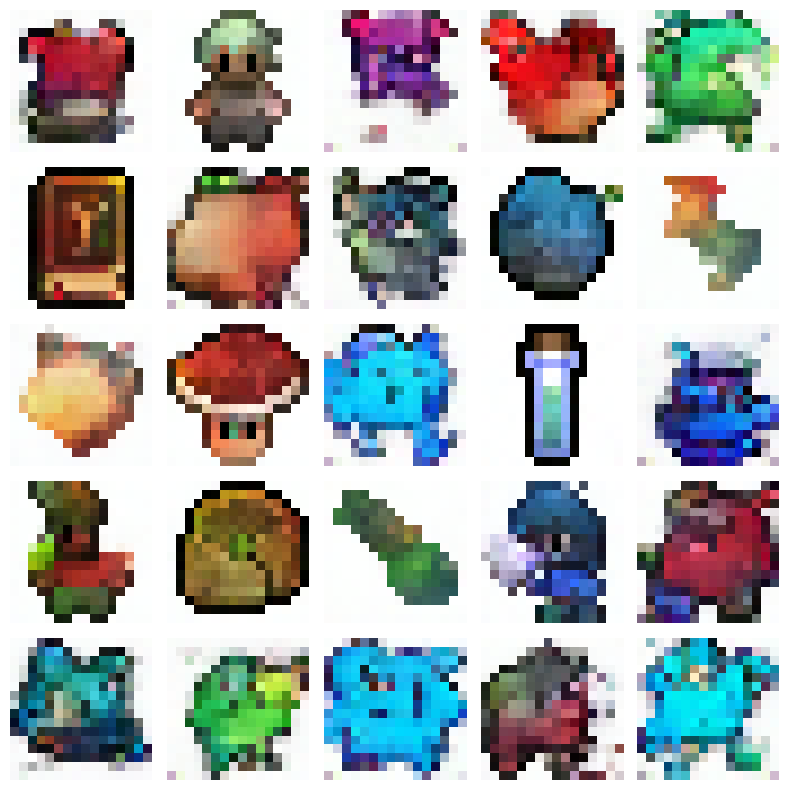

In [ ]:
num_images = 30
generated_images = generate_images(nn_model, num_images, num_timesteps, betas, alpha_cum_prod, sqrt_alpha_cum_prod, sqrt_one_minus_alpha_cum_prod, device)
plot_generated_images(generated_images)

100%|██████████| 1000/1000 [00:06<00:00, 164.17it/s]


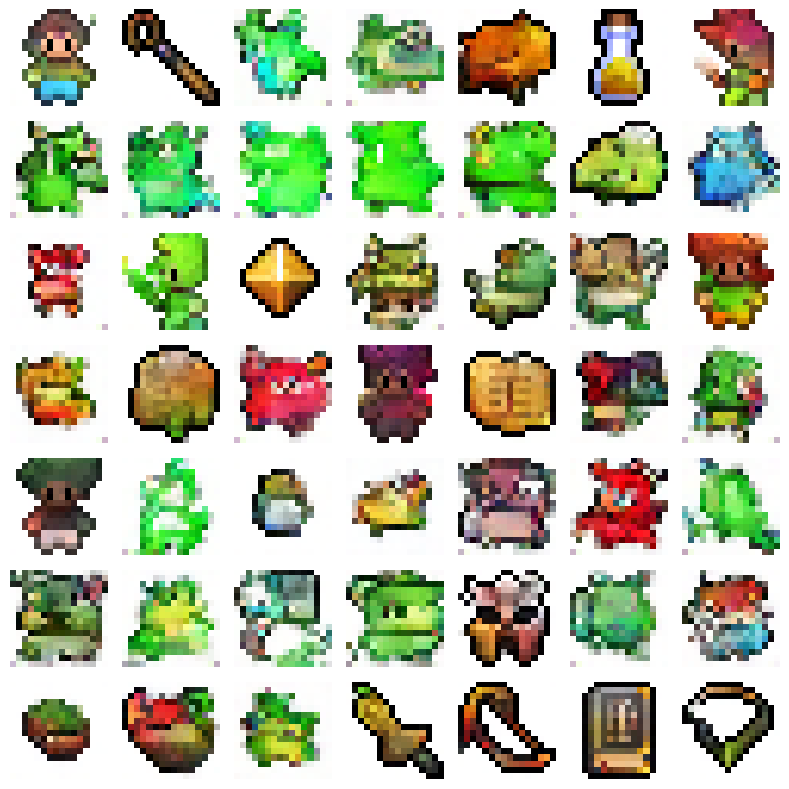

In [ ]:
num_images = 50
generated_images = generate_images(nn_model, num_images, num_timesteps, betas, alpha_cum_prod, sqrt_alpha_cum_prod, sqrt_one_minus_alpha_cum_prod, device)
plot_generated_images(generated_images)

100%|██████████| 1000/1000 [00:05<00:00, 168.15it/s]


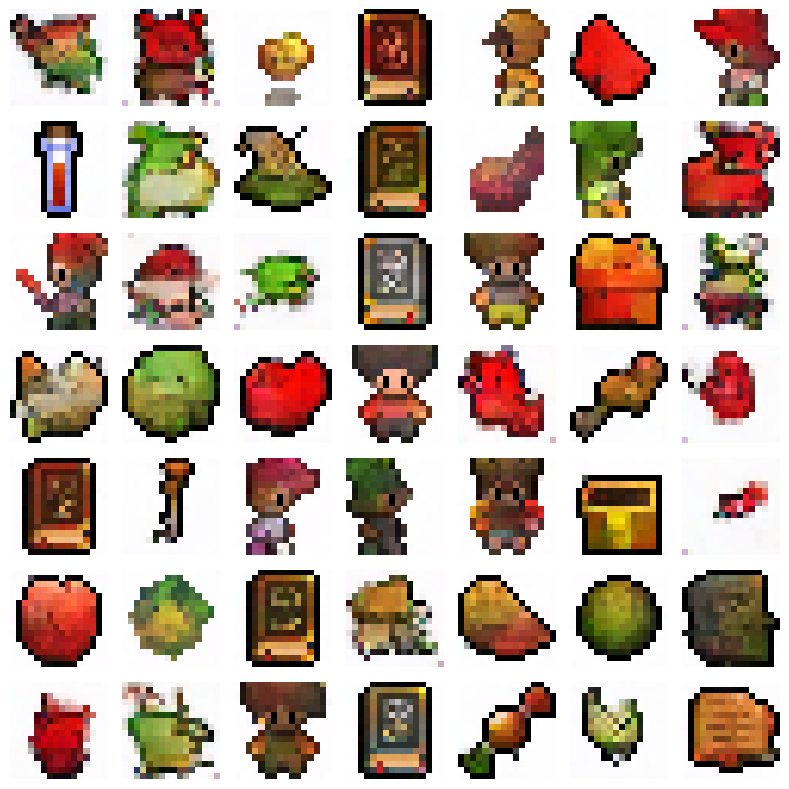

In [ ]:
num_images = 50
generated_images = generate_images(nn_model, num_images, num_timesteps, betas, alpha_cum_prod, sqrt_alpha_cum_prod, sqrt_one_minus_alpha_cum_prod, device)
plot_generated_images(generated_images)

In [ ]:
!pip install pytorch-fid

In [ ]:
from pytorch_fid import fid_score
from pytorch_fid.inception import InceptionV3
transform = transforms.Compose([
    transforms.Resize((16,16)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  ])

real_images = train_dataloader
os.makedirs('generated_images', exist_ok=True)
os.makedirs('real_images', exist_ok=True)

for i, img in enumerate(generated_images):
    img= transforms.ToPILImage()(img.squeeze(0))
    img.save(f'generated_images/img_{i}.png')
for i, real_img_batch in enumerate(real_images):
    for j, real_img in enumerate(real_img_batch):
        img= transforms.ToPILImage()(real_img.squeeze(0))
        img.save(f'real_images/img_{i * len(real_img_batch) + j}.png')

### DDPM samples-FID

In [ ]:
fid_value = fid_score.calculate_fid_given_paths(['generated_images','real_images'],batch_size=50, device='cuda',dims=64)
print(f'FID Score: {fid_value}')

100%|██████████| 1200/1200 [00:48<00:00, 24.78it/s]


FID Score: 2.685545444775788


### DDIM samples-FID

In [ ]:
fid_value = fid_score.calculate_fid_given_paths(['generated_images', 'real_images'], batch_size=50, device='cuda', dims=64)
print(f'FID Score: {fid_value}')

100%|██████████| 1200/1200 [00:48<00:00, 24.90it/s]

FID Score: 9.884496021709056


## Generate images - DDIM

100%|██████████| 1000/1000 [00:05<00:00, 172.68it/s]


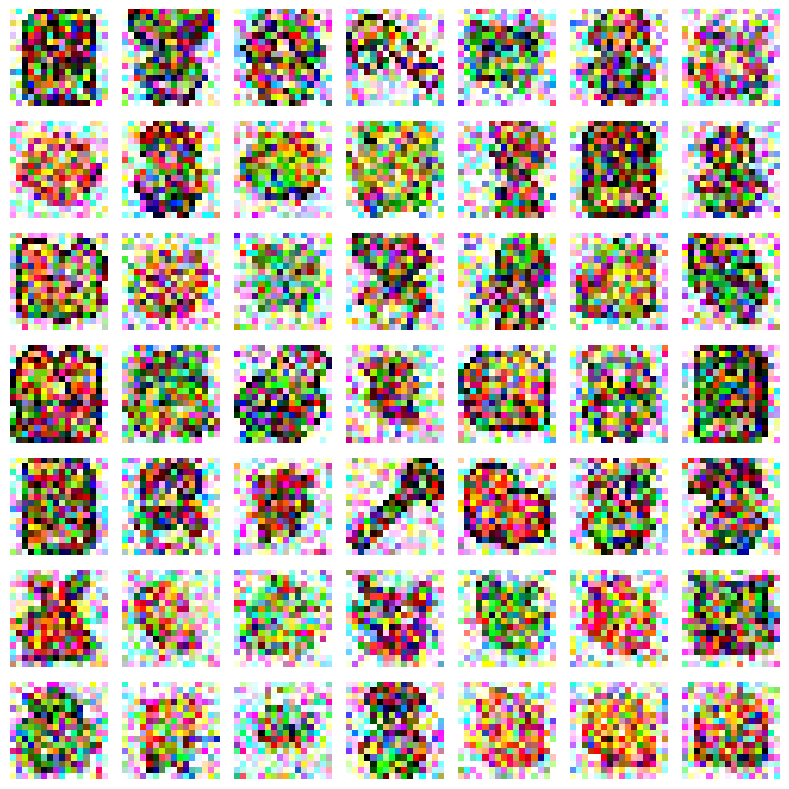

In [ ]:
num_images = 50
generated_images =  generate_images(nn_model, num_images, num_timesteps,
                                    betas, alpha_cum_prod, sqrt_alpha_cum_prod,
                                    sqrt_one_minus_alpha_cum_prod, device,model_type="DDIM",eta=0.8 )
plot_generated_images(generated_images)

# Compare DDIM and DDPM Time

In [ ]:
num_images=50
print('DDPM')
%timeit -r 1 generate_images(nn_model, num_images, num_timesteps, betas, alpha_cum_prod, sqrt_alpha_cum_prod, sqrt_one_minus_alpha_cum_prod, device,model_type="DDPM")
print('DDIM')
%timeit -r 1 generate_images(nn_model, num_images, num_timesteps,betas, alpha_cum_prod, sqrt_alpha_cum_prod,sqrt_one_minus_alpha_cum_prod, device,model_type="DDIM",eta=0.8 )

DDPM


100%|██████████| 1000/1000 [00:05<00:00, 175.26it/s]


5min 12s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
DDIM


100%|██████████| 1000/1000 [00:06<00:00, 165.18it/s]


5min 9s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
import torch
import os
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#model = Unet().to(device)
save_dir = '/content/drive/MyDrive/DDPM'
ep = 69
checkpoint_path = os.path.join(save_dir, f'Epoch_{ep}_checkpoint.pth')
state_dict = torch.load(checkpoint_path)
nn_model.load_state_dict(state_dict)

<ipython-input-159-285e5b4e517f>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(checkpoint_path)


<All keys matched successfully>